## Import packages and set seed

- It is highly probable that the folder "auxiliary_scripts" will change its name in the future.
- If this happens then it would be converted into a package called "wavesuite_auxiliary_scripts" and it would have to be installed and imported

In [1]:
#It is highly probable that this folder will chnage its name in th future
import sys

sys.path.insert(0, '../../auxiliary_scripts/')

test_number = 2    #1 or 2

In [2]:
import numpy as np
import vtktools
import matplotlib.pyplot as plt 

import time  

import torch
import torch.nn as nn 

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
if test_number == 1:
    from test1_just_model3AE import model3_variant1 ,  model3_variant2 ,  model3_variant3 , model3_variant4
    from test1_just_model3AE import model3_variant5 ,  model3_variant6 ,  model3_variant7 , model3_variant8
elif test_number == 2:
    from test2_just_model3AE import model3_variant1 ,  model3_variant2 ,  model3_variant3 , model3_variant4
    from test2_just_model3AE import model3_variant5 ,  model3_variant6 ,  model3_variant7 , model3_variant8

In [4]:
from train_AE_functions import set_seed , train_AE_epoch, validate_AE_epoch , model_MSE_error

from graph_functions import get_node_features, get_complete_edge_list, create_graph_data_list_vtu_file
from plot_results_vtu import plot_model_2d_vtu, compare_four_plots_models_2d_vtu 

from rank_models import plot_losses , rank_losses

In [5]:
from livelossplot import PlotLosses 

set_seed(42)

True

## Create the list of Data objects where each element is a graph

In [6]:
location = '../../../Datasets/air_pollution_data/2d_canyon_' 
start_index = 0
end_index = 401

vtu_file_locations_air = [ location + str(i) + '.vtu' for i in range(start_index, end_index)]
features_list_air = ['TracerBackground']  # ['TracerBackground','Velocity']

In [7]:
graph_data_list_air, n_points = create_graph_data_list_vtu_file(vtu_file_locations_air, features_list_air)

In [8]:
graph_data_list_air[0]

Data(x=[852, 1], edge_index=[2, 2419])

## Shuffle graph_data_list before splitting

In [9]:
#Compute the number of graphs
n_graphs = len(graph_data_list_air)

#Compute one random permutation
permutation0 = np.random.permutation(n_graphs)

In [10]:
shuffle = True

if shuffle:
    #Reorganize graph_data_list taking into account the previous random permutation
    input_graph_data_list = [graph_data_list_air[entry] for entry in permutation0]
else: 
    input_graph_data_list = graph_data_list_air

## Create DataLoaders

In [11]:
n_graphs = len(input_graph_data_list)

graph_data_list_train = input_graph_data_list[:int(n_graphs * 0.8)]
graph_data_list_validation = input_graph_data_list[int(n_graphs * 0.8):int(n_graphs * 0.9)]
graph_data_list_test = input_graph_data_list[int(n_graphs * 0.9):]

print(len(graph_data_list_train))
print(len(graph_data_list_validation))
print(len(graph_data_list_test))

320
40
41


In [12]:
NUM_GRAPHS_PER_BATCH = 32

train_loader = DataLoader(graph_data_list_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(graph_data_list_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(graph_data_list_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Copy train_AE frunction but modify the available model3_variants

In [13]:
def train_AE(train_loader, validation_loader, 
             num_nodes, num_features, embedding_sequence, latent_space_dim,
             ae_model_type='classic_AE', num_epochs=50, plot_losses=True, 
             seed=42, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ,
             use_sgd_instead_of_adam=False, lr=1e-1, momentum=0.2):
    
    set_seed(seed)
    
    invalid_entry = False
    
    if ae_model_type=='model3_variant1':
        model = model3_variant1(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant2':
        model = model3_variant2(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant3':
        model = model3_variant3(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant4':
        model = model3_variant4(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant5':
        model = model3_variant5(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant6':
        model = model3_variant6(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant7':
        model = model3_variant7(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model3_variant8':
        model = model3_variant8(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    else:
        invalid_entry = True
        print('\n An invalid ae_model_type was provided, a classic AE was used as default')
        # model = classic_AE(num_nodes, num_features, latent_space_dim).to(device)
    
    ## The ADAM is the default, since the ADAM optimizer performs better in this case compared against SGD  
    optimizer = torch.optim.Adam(model.parameters())
    if use_sgd_instead_of_adam:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    ## The loss here is the mean_squared_error because the model is an AE
    criterion = nn.MSELoss()
    
    if plot_losses:
        liveloss = PlotLosses()
    loss_register = []
    
    for epoch in range(num_epochs):
        #During each epoch update the parameters
        train_temp_loss = train_AE_epoch(model, optimizer, criterion, train_loader, device, num_nodes)
        
        #Optional: Check the validation loss in each epoch
        validation_temp_loss = validate_AE_epoch(model, criterion, validation_loader, device, num_nodes) 
        
        #Compute the losses in each iteration 
        logs = {}
        logs['' + 'log loss'] = train_temp_loss.item()
        logs['val_' + 'log loss'] = validation_temp_loss.item()
        loss_register.append(logs)
        
        #Optionally plot the train and validation loss   
        if plot_losses:
            liveloss.update(logs)
            liveloss.draw()
            
    if invalid_entry == True:
        print('\n An invalid ae_model_type was provided, a classic AE was used as default') 
        
    print("\n Number of parameters: ", sum(p.numel() for p in model.parameters()))
    
    #At the end just return 1. the model with the trained parameters and 2. the list of losses in every epoch
    return model, loss_register 


## Let's train some models

In [14]:
#This dictionary stores the losses results of the models
results_variants = {}

In [15]:
#These are the models specifications
num_features = 1  #This is always 1
embedding_sequence = [8, 16, 2, 2, 16, 8] 
latent_space_dim = 32
num_epochs = 50   #CHANGE, change it back to 50  

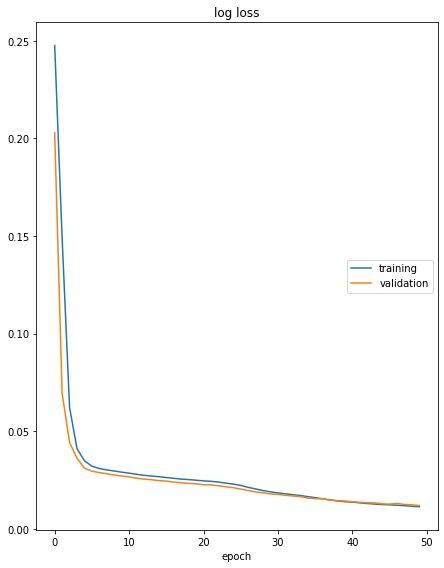

log loss
	training         	 (min:    0.011, max:    0.248, cur:    0.011)
	validation       	 (min:    0.012, max:    0.203, cur:    0.012)

 Number of parameters:  224459
Time taken:  17.64987349510193


In [16]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant1'

variant1, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant1', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

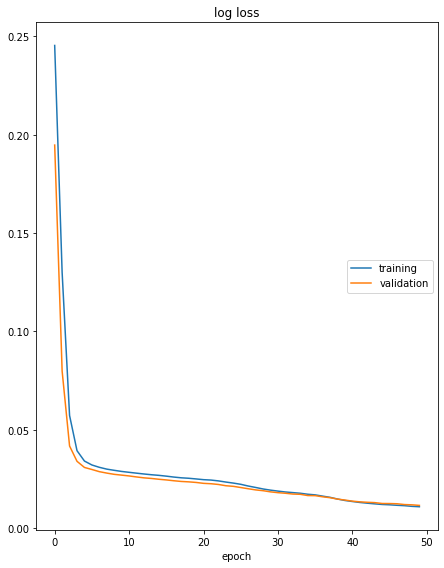

log loss
	training         	 (min:    0.011, max:    0.245, cur:    0.011)
	validation       	 (min:    0.012, max:    0.195, cur:    0.012)

 Number of parameters:  224459
Time taken:  15.286257982254028


In [17]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant2'

variant2, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant2', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

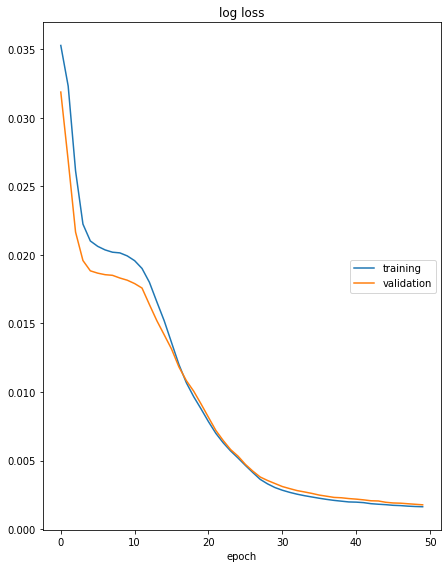

log loss
	training         	 (min:    0.002, max:    0.035, cur:    0.002)
	validation       	 (min:    0.002, max:    0.032, cur:    0.002)

 Number of parameters:  224459
Time taken:  15.737140893936157


In [18]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant3'

variant3, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant3', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

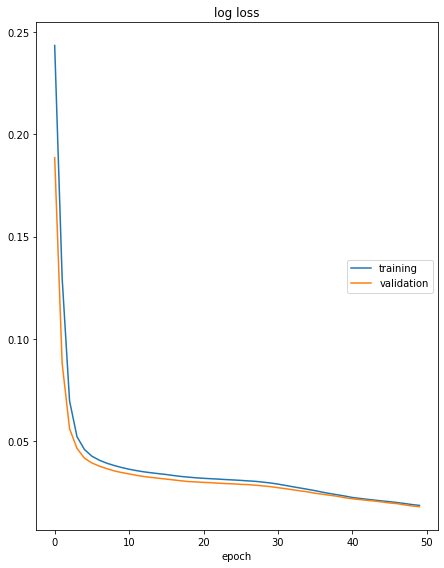

log loss
	training         	 (min:    0.018, max:    0.244, cur:    0.018)
	validation       	 (min:    0.018, max:    0.189, cur:    0.018)

 Number of parameters:  224459
Time taken:  15.499136447906494


In [19]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant4'

variant4, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant4', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

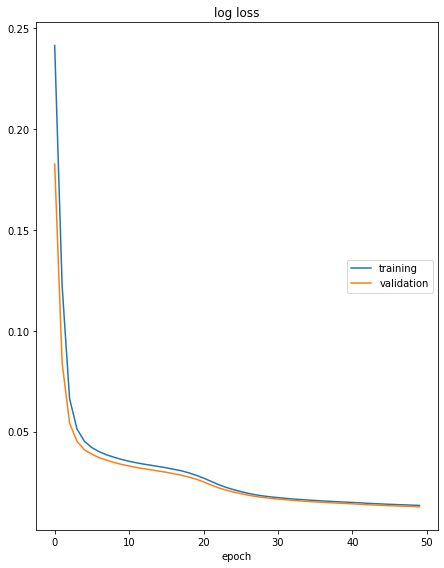

log loss
	training         	 (min:    0.013, max:    0.241, cur:    0.013)
	validation       	 (min:    0.013, max:    0.183, cur:    0.013)

 Number of parameters:  224459
Time taken:  15.488683462142944


In [20]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant5'

variant5, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant5', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

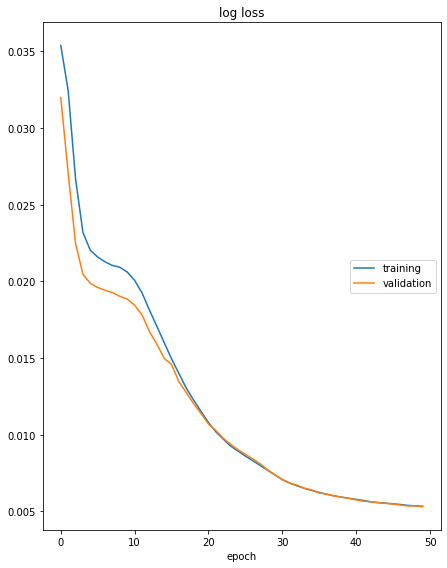

log loss
	training         	 (min:    0.005, max:    0.035, cur:    0.005)
	validation       	 (min:    0.005, max:    0.032, cur:    0.005)

 Number of parameters:  224459
Time taken:  15.779979705810547


In [21]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant6'

variant6, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant6', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

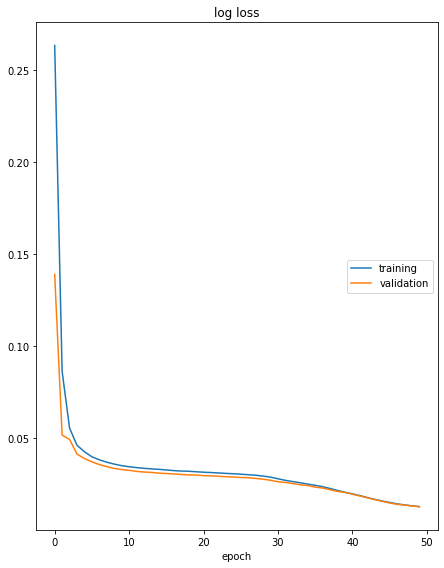

log loss
	training         	 (min:    0.013, max:    0.264, cur:    0.013)
	validation       	 (min:    0.013, max:    0.139, cur:    0.013)

 Number of parameters:  224459
Time taken:  15.390391826629639


In [22]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant7'

variant7, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant7', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

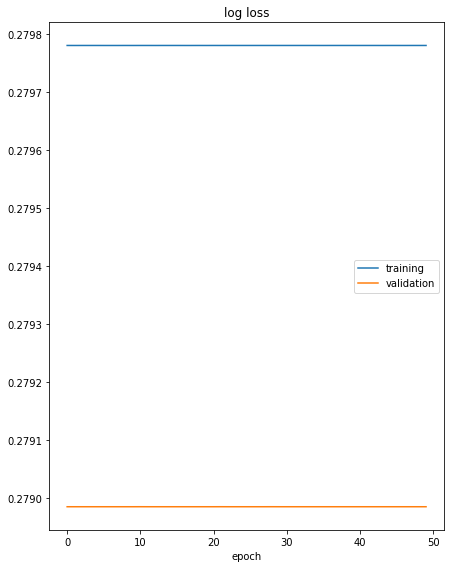

log loss
	training         	 (min:    0.280, max:    0.280, cur:    0.280)
	validation       	 (min:    0.279, max:    0.279, cur:    0.279)

 Number of parameters:  224459
Time taken:  15.973020076751709


In [23]:
start = time.time()

var_name = 'test'+str(test_number)+'_variant8'

variant8, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model3_variant8', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

## MSE results

In [24]:
variants_names = list( results_variants.keys() )

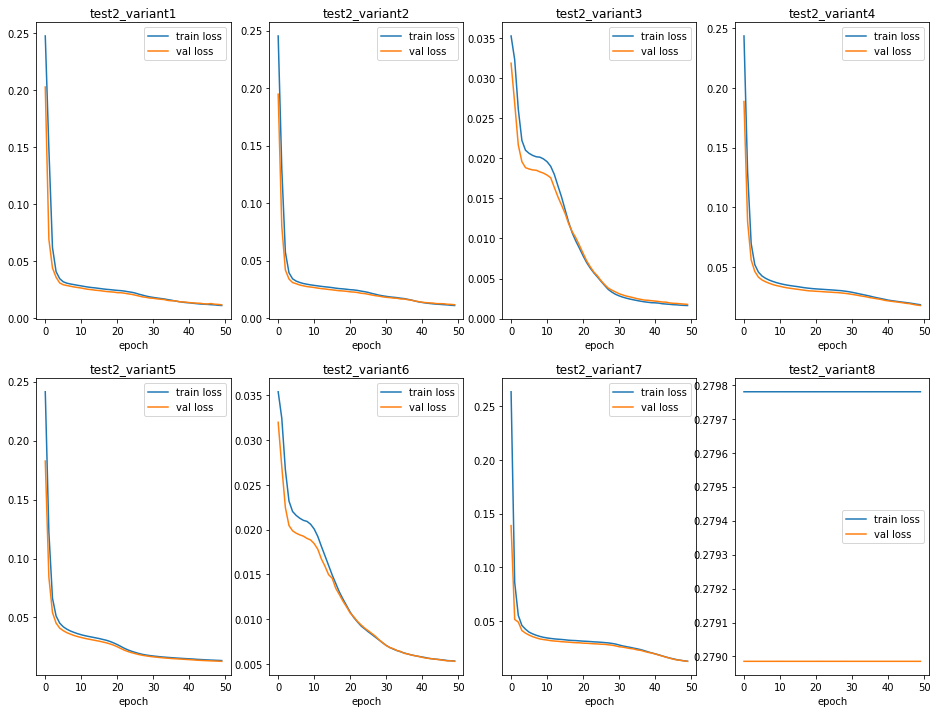

In [25]:
filename = 'model3_air_pollution_test'+str(test_number)+'_variants_losses.png' 
plot_losses(results_variants, variants_names, filename=filename, figsize=(16,12))

In [26]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,test2_variant3,0.017580
1,test2_variant6,0.017816
2,test2_variant1,0.025960
3,test2_variant2,0.026033
4,test2_variant7,0.031809
5,test2_variant5,0.032232
6,test2_variant4,0.033184
7,test2_variant8,0.278986


In [27]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,test2_variant3,0.005327
1,test2_variant6,0.009017
2,test2_variant5,0.020104
3,test2_variant1,0.021085
4,test2_variant2,0.021264
5,test2_variant7,0.028754
6,test2_variant4,0.029026
7,test2_variant8,0.278986


In [28]:
first_column_model_name = 'Model3'
filename = 'model3_air_pollution_test'+str(test_number)+'_variants_losses.csv'

df_losses = rank_losses(results_variants, variants_names, selected_epoch = num_epochs,
                       first_column_model_name = first_column_model_name, filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,Model3,test2_variant3,0.001778
1,Model3,test2_variant6,0.005306
2,Model3,test2_variant2,0.011569
3,Model3,test2_variant1,0.011916
4,Model3,test2_variant7,0.012568
5,Model3,test2_variant5,0.012790
6,Model3,test2_variant4,0.017826
7,Model3,test2_variant8,0.278986


In [29]:
#print( 'model3_variant1 error: ', model_MSE_error(variant1, train_loader) )
#print( 'model3_variant2 error: ', model_MSE_error(variant2, train_loader) )
#print( 'model3_variant3 error: ', model_MSE_error(variant3, train_loader) )
#print( 'model3_variant4 error: ', model_MSE_error(variant4, train_loader) )
#print( 'model3_variant5 error: ', model_MSE_error(variant5, train_loader) )
#print( 'model3_variant6 error: ', model_MSE_error(variant6, train_loader) )
#print( 'model3_variant7 error: ', model_MSE_error(variant7, train_loader) )
#print( 'model3_variant8 error: ', model_MSE_error(variant8, train_loader) )

- Note that VARIANT 8 does not even converge

# Plot the results

In [30]:
filename_to_copy_structure = '../../../Datasets/air_pollution_data/2d_canyon_0.vtu'

Indexes plotted [1, 10, 20, 39]


C:\Users\angel\Anaconda3\envs\second-try-alienware\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


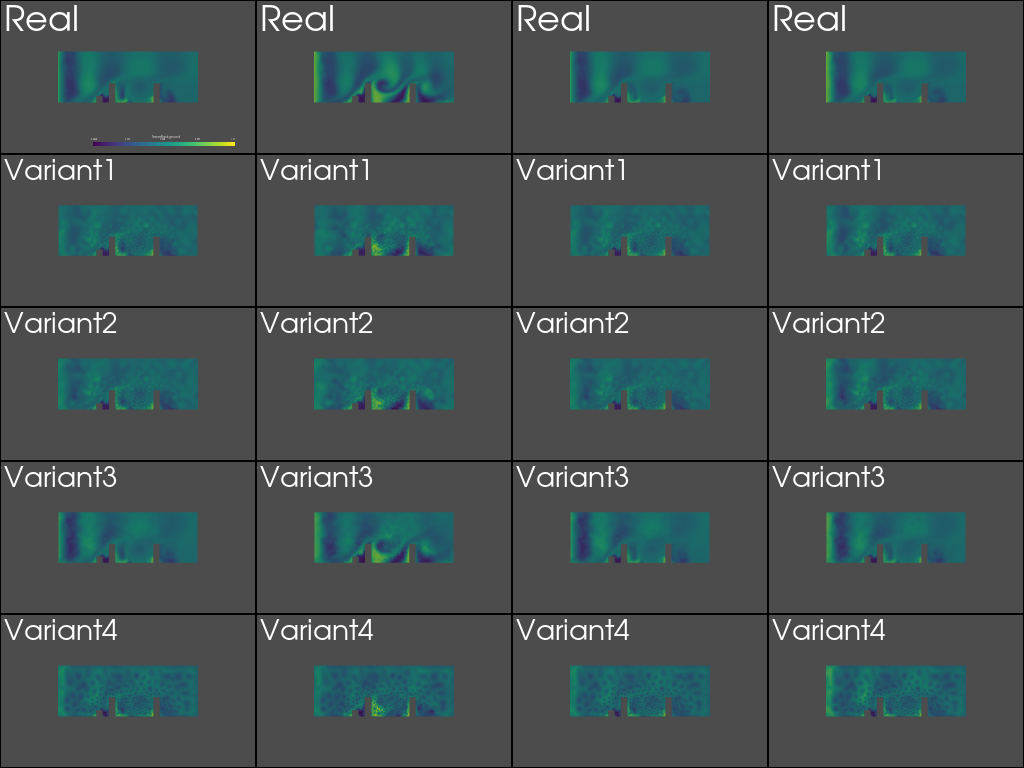

In [31]:
compare_four_plots_models_2d_vtu(variant1, variant2, variant3, variant4, 
                            graph_data_list_test, 3 , filename_to_copy_structure, 
                            random=False, index_sequence=[ 1, 10, 20, 39], 
                           set_pred_labels_as = ["Variant1", "Variant2", "Variant3", "Variant4"],
                                 save_fig=True, filename='air_pollution_model3'+'_test'+str(test_number)+'_variants_1to4.eps' )

Indexes plotted [38 28 14]


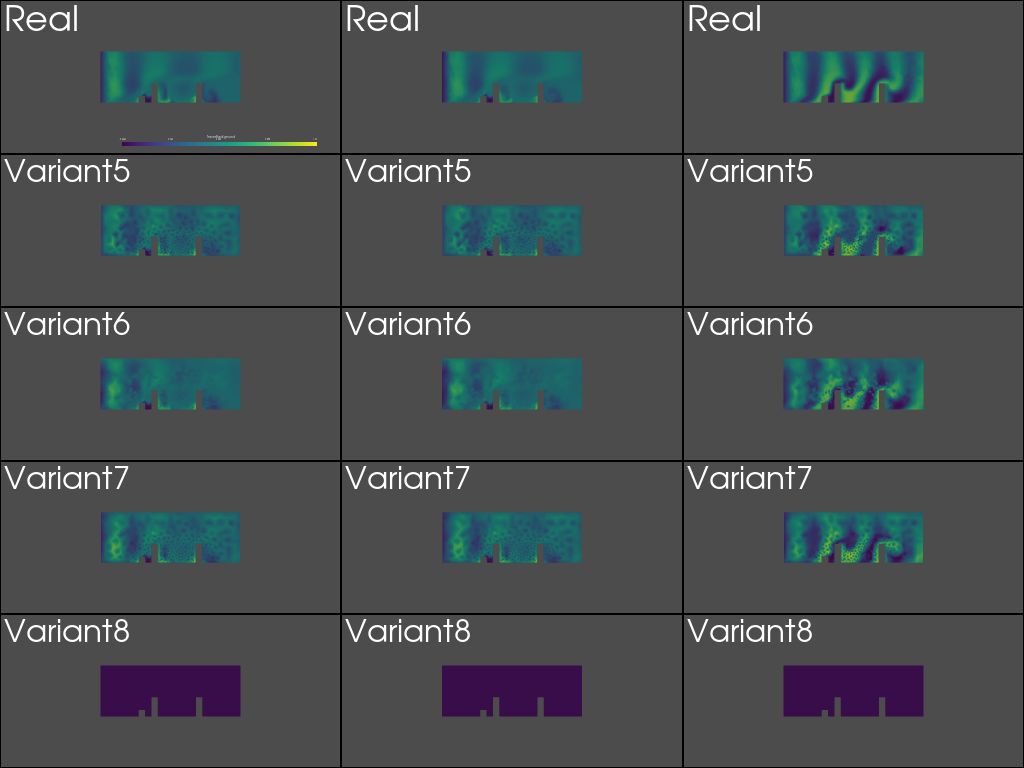

In [32]:
compare_four_plots_models_2d_vtu(variant5, variant6, variant7, variant8, 
                            graph_data_list_test, 3 , filename_to_copy_structure, 
                            random=True, 
                           set_pred_labels_as = ["Variant5", "Variant6", "Variant7", "Variant8"],
                                 save_fig=True, filename='air_pollution_model3'+'_test'+str(test_number)+'_variants_5to8.eps')

The best results were obtained by variant3 and it is also possible to plot results for this model only

Indexes plotted [ 7 20]


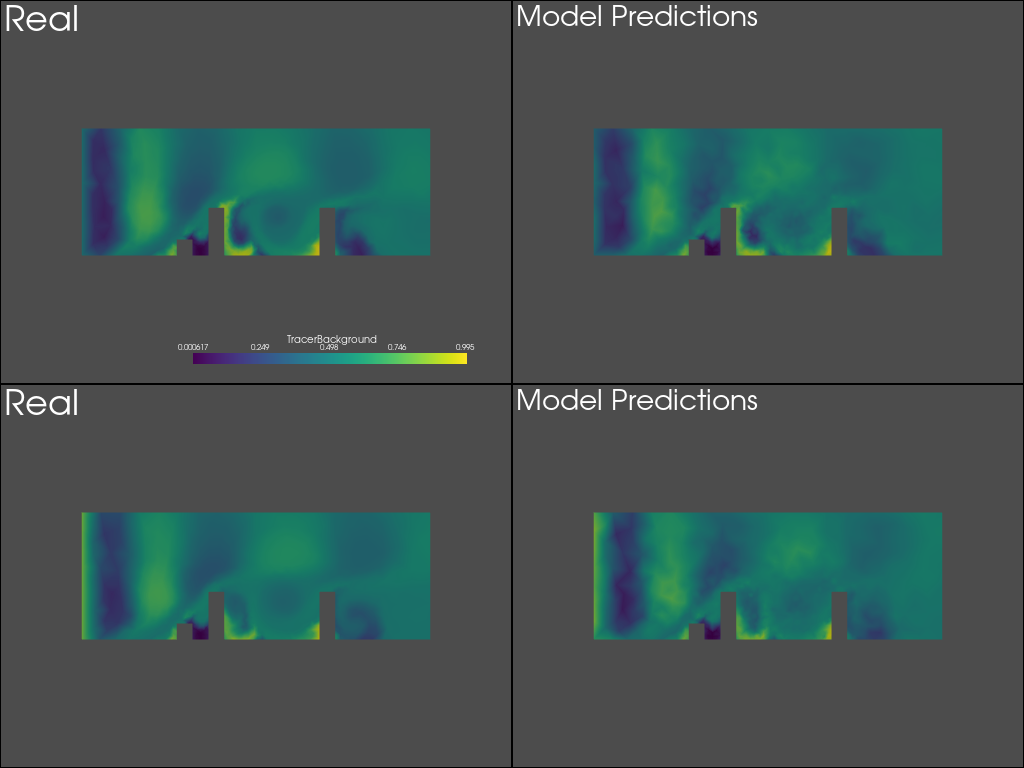

In [33]:
plot_model_2d_vtu(variant3, graph_data_list_test, 2 , filename_to_copy_structure , random=True)